# ["Buffer-Stock Saving and the Life Cycle/Permanent Income Hypothesis](https://www.jstor.org/stable/2951275?seq=1#page_scan_tab_contents)"
- Christopher D. Carroll
- Notebook is prepared by Yusuf Suha Kulu and Jeongwon (John) Son

### Summary

This paper argues that the saving behaviour of a household is better described by the buffer stock version of the Life Cycle/Permanent Income Hypothesis (LC/PIH) than the traditional version of it. Buffer Stock Consumers set average consumption growth equal to average labor income growth, regardless of tastes. The buffer stock model predicts a higher marginal propensity to consume (MPC) out of transitory income, higher effective discount rate for future labor income, and a positive sign for the correlation between saving and expected labor income growth.

The finite horizon version of the model presented in the paper explains three emprical puzzles.

1. __Consumption/income parallel :__  Aggregate consumption parallels growth in income over periods of more than a few years.
2. __Consumption/income divergence :__ For individual households, consumption is far from current income. This implies the consumption/income parallel does not arise at the household level.
3. __Stability of the household age/wealth profile :__ The effects of the productivity growth slowdown after 1973 on the age/median-wealth profile and the extraordinarily high volatility of the household liquid wealth are explained. 


The traditional model is the following:

Finite Horizon  

$$c_t = \kappa_t[m_t + h_t]$$ 
$$h_t = \sum_{i=t+1}^{T}R^{i-t}y_{i} $$
$$\kappa_t = \frac{(1 - {[R^{-1}(\beta R)^{1/\rho}]})}{(1 - {[R^{-1}(\beta R)^{1/\rho}]}^{T-t+1})}$$



Infinite Horizon 

$$c_t = \kappa_t[m_t + h_t]$$
$$h_t = \sum_{i=t+1}^{\infty}R^{i-t}y_{i} \approx \frac{y_t}{r - g}$$
$$\kappa = {(1 - {[R^{-1}(\beta R)^{1/\rho}]})}$$

### Model Setup

 

The consumer solves the following intertemporal optimization problem. 

 

$$ \max \quad E_t \Sigma_{n=0}^{T-t} \beta^{n}u(c_{t+n}) $$

\begin{aligned} \text{s.t.} \quad b_{t+1} &= R[b_t + y_t - c_t]\\
y_t &= p_tv_t\\
p_t &= G_tp_{t-1}n_t 
\end{aligned}

$y$: current labor income 

$p$: permanent labor income 

$v$: transitory income shock 

$n$: permanent income shock

$G = (1+g)$: growth factor for permanent labor income 

$b$: stock of physical net wealth 

$R = (1+r)$: gross interest rate 

$\beta = 1/(1+\delta)$: discount factor

 

Solving the consumer's optimization problem gives the following Euler equation. 

 

$$1= R\beta E_{t-1}[\{c_t[R[m_{t-1}-c_{t-1}]/Gn_t + v_t]Gn_t/c_{t-1}\}^{-\rho}]$$ 

Lower case variables are defined as the uppercase variables divided by the current level of permanent income. 

$m = b+y$: gross wealth

 

Since this is a life cycle model, the consumer consumes everything in the last period:$c_T[m_T] = m_t$. This implies that by recursion, the Euler equation gives the consumption ratio for each period. 

 

If shocks to consumption are assumed to be lognormally distributed, a log-linearized version of the Euler equation takes the following form.

 

$$ E_t\Delta \ln c_{t+1} \approx \rho^{-1}(r-\delta) + (\rho/2)\text{var}_t(\Delta\ln c_{t+1}) + e_{t+1} $$

 

The figure below depicts expected consumption growth. As can be seen from the directional arrows, there is a target level of wealth ratio and consumption ratio.

In [1]:
# This cell has a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

#from util import log_progress

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

In [2]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.02
Rfree      = 1
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint



In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
baseEx_inf = IndShockConsumerType(cycles=0,**base_params)

baseEx_inf.solve()
baseEx_inf.unpackcFunc()

The given type violates the finite human wealth condition; the finite human wealth factor value 1.02000 


In [4]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFactp1 = baseEx_inf.PermGroFac[0]* baseEx_inf.PermShkDstn[0][1]
    Rnrmtp1 = baseEx_inf.Rfree / GrowFactp1
    # end-of-period assets plus normalized returns
    btp1 = Rnrmtp1*a
    # expand dims of btp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    mtp1 = np.expand_dims(btp1, axis=1) + baseEx_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*baseEx_inf.cFunc[0](mtp1).T
    # finish expectation over permanent income shocks by right multiplying with
    # the weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf.PermShkDstn[0][0])
    # finish expectation over transitory income shocks by right multiplying with
    # weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [5]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,baseEx_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = baseEx_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = [exp_consumption(i) for i in a1]

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(baseEx_inf.solution[0].mNrmSS,1.9,50)

c_m2 = baseEx_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = [exp_consumption(i) for i in a2]

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

(0.98, 1.08)

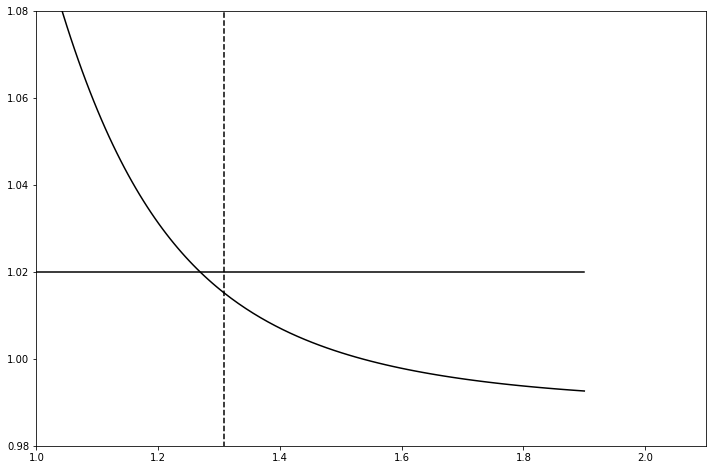

In [6]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
#arrowplot(ax, m1,growth1)
#arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)

In [7]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.005
Rfree      = 1
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params1 = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params1['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params1['Rfree']      = Rfree          # Interest factor on assets
base_params1['DiscFac']    = DiscFac        # Time Preference Factor
base_params1['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params1['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params1['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params1['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params1['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params1['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params1['CubicBool']    = True    # Use cubic spline interpolation
base_params1['T_cycle']      = 1       # No 'seasonal' cycles
base_params1['BoroCnstArt']  = None    # No artificial borrowing constraint

In [8]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
baseEx_inf1 = IndShockConsumerType(cycles=0,**base_params1)

baseEx_inf1.solve()
baseEx_inf1.unpackcFunc()


The given type violates the finite human wealth condition; the finite human wealth factor value 1.00500 


In [9]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFactp1 = baseEx_inf1.PermGroFac[0]* baseEx_inf1.PermShkDstn[0][1]
    Rnrmtp1 = baseEx_inf1.Rfree / GrowFactp1
    # end-of-period assets plus normalized returns
    btp1 = Rnrmtp1*a
    # expand dims of btp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    mtp1 = np.expand_dims(btp1, axis=1) + baseEx_inf1.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*baseEx_inf1.cFunc[0](mtp1).T
    # finish expectation over permanent income shocks by right multiplying with
    # the weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf1.PermShkDstn[0][0])
    # finish expectation over transitory income shocks by right multiplying with
    # weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf1.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [10]:
# Calculate the expected consumption growth factor
m11 = np.linspace(1,baseEx_inf1.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m11 = baseEx_inf1.cFunc[0](m11)
a11 = m11-c_m11
exp_consumption_l11 = [exp_consumption(i) for i in a11]

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth11 = np.array(exp_consumption_l11)/c_m11

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m21 = np.linspace(baseEx_inf1.solution[0].mNrmSS,1.9,50)

c_m21 = baseEx_inf1.cFunc[0](m21)
a21 = m21-c_m21
exp_consumption_l21 = [exp_consumption(i) for i in a21]

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth21 = np.array(exp_consumption_l21)/c_m21

(0.98, 1.08)

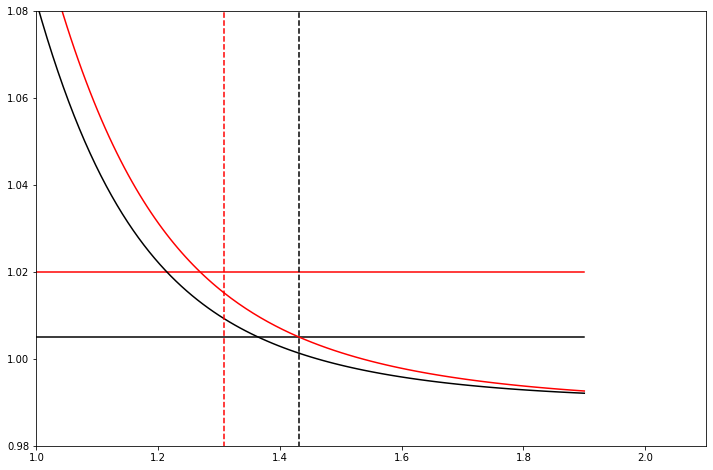

In [14]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac1 = (baseEx_inf1.Rfree*baseEx_inf1.DiscFac)**(1.0/baseEx_inf1.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac1,AbsPatientFac1],color="black")
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="red")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf1.PermGroFac[0],baseEx_inf1.PermGroFac[0]],color="black")
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="red")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m11,growth11,color="black")
ax.plot(m1,growth1,color="red")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m21,growth21,color="black")
ax.plot(m2,growth2,color="red")
# Plot the arrows
#arrowplot(ax, m1,growth1)
#arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf1.solution[0].mNrmSS,baseEx_inf1.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="red",linestyle="--")

ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)

### Methods of Solution

 

The optimal consumption for a given value of gross wealth, $c_t(m_t)$, is derived by solving the Euler equation recursively backwards.

 

1. $c_T(m_T) = m_T$

2. For $n$ values of $m_{T-1}$, by using the Euler equation, compute the corresponding $n$ values of $c_{T-1}(m_{T-1})$.

3. Using cubic interpolation for values of $m_{T-1}$ between the n values, numerically calculate the function $c_{T-1}(m_{T-1})$.

4. Given $c_{T-1}(m_{T-1})$, use the same methods as 2 and 3 to numerically solve for $c_{T-2}(m_{T-2})$.

5. Continue this method until period $t$.

 

For the infinite horizon version of this model, the following convergence criterion is used.

$$\frac{1}{n}\Sigma\vert c_t(m_i) - c_{t+1}(m_i)\vert < 0.0005$$

### Resolving Three Emprical Puzzles

#### 1) The Consumption/Income Parallel in Low Frequency Data

Consumption growth and income growth are very closely linked over periods of a few years or longer.

Three age/income profiles calibrated using the data for Unskilled Laborers, Operatives, and Managers.
1. For Unskilled Labor,labor income grows at 3% annually from ages 25 to 40, and is flat from age 40 to retirement at 65.
2. For Operatives, labor income grows at 2.5% annually from the age 25 to 50, then 1% per year until retirement.
3. For Managers, income grows at 3% from ages 25 to 55, and declines at 1% per year from 55 to 65.

Post-retirement income is assumed to equal 70 percent income in the last year of the working life, for all three groups. 

In [15]:
import HARK.ConsumptionSaving.ConsIndShockModel as Model        # The consumption-saving micro model
import HARK.ConsumptionSaving.ConsumerParameters as Params    # Parameters for the consumer type
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools
from time import time
mystr = lambda number : "{:.4f}".format(number)
do_simulation = True
import numpy as np
import matplotlib.pyplot as plt

#Notebooks to look for helpful code
# https://github.com/econ-ark/HARK/blob/master/HARK/SolvingMicroDSOPs/Code/StructEstimation.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsIndShockModel.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsumerParameters.py
# https://github.com/matthew-zahn/CGMPort/blob/develop/REMARK/CGM_REMARK.ipynb

In [16]:
#Set Parameters

Params.init_lifecycle["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_lifecycle["DiscFac"]= 0.96         # Default intertemporal discount factor (beta)
Params.init_lifecycle["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_lifecycle["aNrmInitMean"]= 0       # Mean of log initial assets 
Params.init_lifecycle["aNrmInitStd"]= 0.0      # Standard deviation of log initial assets
Params.init_lifecycle["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_lifecycle["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

Params.init_lifecycle['AgentCount'] = 1000                  #Change the number of agents simulated from default 10000 to 1000

Params.init_lifecycle['PermShkStd'] = [0.1]*50               #Originally, [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0]
Params.init_lifecycle['TranShkStd'] = [0.1]*50               #Originally, [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0]
Params.init_lifecycle['LivPrb']     = [1]*50                 #Originally, [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
Params.init_lifecycle['T_cycle']    = 50                     #Life starts at age 25 and ends at 75. Originally 10
Params.init_lifecycle['T_retire']   = 40                    #Agents retire at age 65. Originally 7
Params.init_lifecycle['T_age']      = 51                    #Make sure that old people die at terminal age and don't turn into newborns! Originally 11

In [17]:
#Unskilled Laborers: 3 percent growth from 25~40. flat for 40~65.

Params.init_lifecycle['PermGroFac'] = [1.03]*15 + [1]*25 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]

Lifecycle_Unskilled = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Unskilled.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Unskilled.solve()
Lifecycle_Unskilled.unpackcFunc()
Lifecycle_Unskilled.timeFwd() #make sure that time is moving forward

In [18]:
#Operatives: 2.5 percent growth from 25~50. 1 percent growth from 50~65.

Params.init_lifecycle['PermGroFac'] = [1.025]*25 + [1.01]*15 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]

Lifecycle_Operatives = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Operatives.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Operatives.solve()
Lifecycle_Operatives.unpackcFunc()
Lifecycle_Operatives.timeFwd() #make sure that time is moving forward

In [19]:
#Managers: 3 percent growth from 25~55. 1 percent decline from 55~65.

Params.init_lifecycle['PermGroFac'] = [1.03]*30 + [0.99]*10 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]

Lifecycle_Managers = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Managers.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Managers.solve()
Lifecycle_Managers.unpackcFunc()
Lifecycle_Managers.timeFwd() #make sure that time is moving forward

In [20]:
#This is only for showing the consumption function so we don't need to have it run

#print('Consumption functions while working:')


#mMin = min([Lifecycle_Unskilled.solution[t].mNrmMin for t in range(Lifecycle_Unskilled.T_cycle)])
   #Finds the minimum of Lifecycle_Unskilled.solution[t].mNrmMin for t = 0~49
   #mNrmMin: The minimum allowable market resources for this period; the consumption function (etc) are undefined for m < mNrmMin.


#plotFuncs(Lifecycle_Unskilled.cFunc[:Lifecycle_Unskilled.T_retire],mMin,5)
   #This plots the consumption function for life periods 0~40. Plots it with respect to wealth from 0 to 5.
   #The highest curve is for period 0.

#print('Consumption functions while retired:')
#plotFuncs(Lifecycle_Unskilled.cFunc[Lifecycle_Unskilled.T_retire:],0,5)
   #Highest graph represents consumption in last period. MPC is 1 since the consumer consumes everything in the second to last period.

#Lifecycle_Unskilled.timeRev()
   #Set time to reverse so that simulations solve using backward induction

In [21]:
if do_simulation:
    Lifecycle_Unskilled.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Unskilled.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Unskilled.initializeSim()
    Lifecycle_Unskilled.simulate()
    
if do_simulation:
    Lifecycle_Operatives.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Operatives.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Operatives.initializeSim()
    Lifecycle_Operatives.simulate()

if do_simulation:
    Lifecycle_Managers.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Managers.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Managers.initializeSim()
    Lifecycle_Managers.simulate()

In [22]:
import pandas as pd
raw_data = {'T_age': Lifecycle_Unskilled.t_age_hist.flatten()+24, #add 24 to make the starting period 25. age is same for all occupations so so need to make three of these.
            'cNrmNow_Unskilled': Lifecycle_Unskilled.cNrmNow_hist.flatten(),
            'pLvlNow_Unskilled': Lifecycle_Unskilled.pLvlNow_hist.flatten(),
            'mNrmNow_Unskilled': Lifecycle_Unskilled.mNrmNow_hist.flatten(),
            'cNrmNow_Operatives': Lifecycle_Operatives.cNrmNow_hist.flatten(),
            'pLvlNow_Operatives': Lifecycle_Operatives.pLvlNow_hist.flatten(),
            'mNrmNow_Operatives': Lifecycle_Operatives.mNrmNow_hist.flatten(), 
            'cNrmNow_Managers': Lifecycle_Managers.cNrmNow_hist.flatten(),
            'pLvlNow_Managers': Lifecycle_Managers.pLvlNow_hist.flatten(),
            'mNrmNow_Managers': Lifecycle_Managers.mNrmNow_hist.flatten(),}

#Make the simulated results into a dataset

Data = pd.DataFrame(raw_data) #make the raw data into a formal dataset
Data['Cons_Unskilled'] = Data.cNrmNow_Unskilled * Data.pLvlNow_Unskilled #cNrmNow has to be multiplied by pLvlNow
Data['Cons_Operatives'] = Data.cNrmNow_Operatives * Data.pLvlNow_Operatives
Data['Cons_Managers'] = Data.cNrmNow_Managers * Data.pLvlNow_Managers

Data['Inc_Unskilled'] = Data.pLvlNow_Unskilled
Data['Inc_Operatives'] = Data.pLvlNow_Operatives 
Data['Inc_Managers'] = Data.pLvlNow_Managers
#Data['M'] = Data.nrmM * Data.pIncome

AgeMeans = Data.groupby(['T_age']).mean().reset_index() # Group the dataset by T_age and get the mean.

Text(0.5, 1.0, 'Managers')

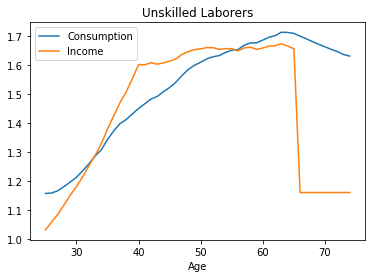

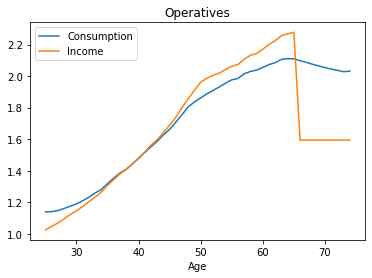

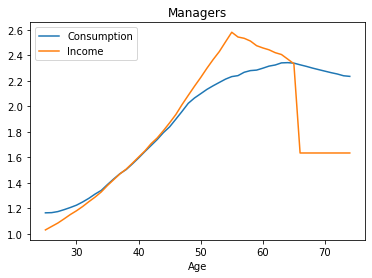

In [23]:
plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Unskilled,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Unskilled,label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Unskilled Laborers')

plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Operatives,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Operatives, label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Operatives')

plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Managers,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Managers, label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Managers')

Results show the paralell until the age of 45 or 50. Then retirement savings allow income profile to rise above the consumption profile in the years immediately before the retirement.

#### 2) The Consumption/Income Divergence in High Frequency Data

The Buffer-Stock model has no difficulty generating an MPC large enough to match emprical estimates, while the standard LC/PIH model is simply incapable of implying large values for the MPC out of transitory income. 

#### 3) The Behaviour of Wealth over the Lifetime

Median ratio of wealth(financial assets) to income(annual income) is between 2 and 35 percent at all ages before the retirement. This fact is stable over the early 1960s and the late 1980s but there was a sharp slowdown(post-1973) in the productivity growth within this period. 

The productivity growth slowdown is assumed to result in a 1 percent slower growth rate of labor income over the working labor income. 

This fact is not explained by the standard LC/PIH model as the lower growth induce an enourmous increase in household wealth at all ages greater than 30. On average, the slower curve is higher than the faster curve by an amount equal to roughly two years' worth of income. Thus, the model predicts enourmous increase in household wealth/income ratios due to the productivity slowdown. 

The results for the same experiment with the buffer-stock model are shown below;

The difference between the two productivity growth scenarios is not remotely so dramatic as in the standard model.


### Conclusion 

This paper argues that a version of the LC/PIH model is closer both to the behaviour of the typical household and to Friedman's original conception of the Permanent Income Hypothesis model. The buffer-stock version of the model can explain why consumption tracks income closely when aggregated by groups or in whole economies, but is often sharply different from income at the level of individual households. The model is consistent having higher MPC out of transitory income without imposing liquidity constraints. Further, it provides an explanation for why median household wealth/income ratios have remained roughly stable despite a sharp slowdown in expected income growth. 